<a href="https://colab.research.google.com/github/davione112/Collection_Preprocessing/blob/master/BikeSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**




In [114]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# **Dataset**

In [8]:
url1 = 'https://raw.githubusercontent.com/davione112/work/master/train.csv'
url2 = 'https://raw.githubusercontent.com/davione112/work/master/test.csv'
train = pd.read_csv(url1)
test = pd.read_csv(url2)

- Brief summaries:


In [9]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [12]:
dataset.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

- Check for missing data

In [ ]:
train.isnull()

In [ ]:
test.isnull()

- Combine train and test into a dataset.

In [19]:
dataset = train.append(test)
dataset.reset_index(inplace=True)
dataset.drop('index',inplace=True,axis=1)

In [20]:
dataset.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


# Understand variables


In [23]:
dataset.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual        float64
registered    float64
count         float64
dtype: object

- Distributions of continuous variables

Text(0.5, 1.0, 'Windspeed')

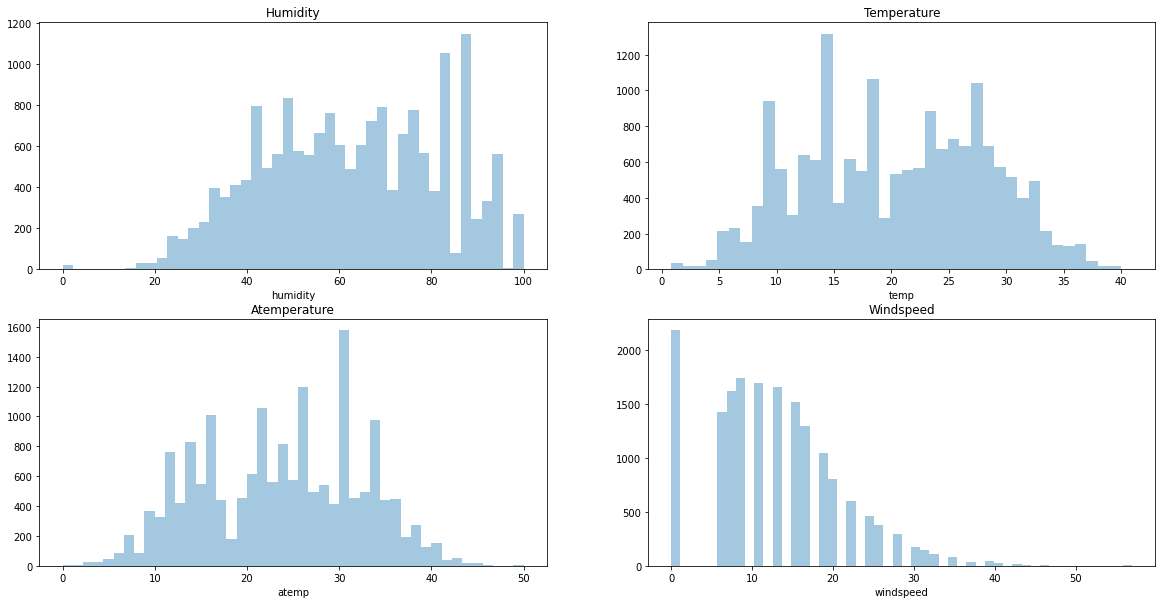

In [77]:
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sb.distplot(dataset["humidity"],kde=False,ax=ax[0,0])
sb.distplot(dataset["temp"],kde=False,ax=ax[0,1])
sb.distplot(dataset["atemp"],kde=False,ax=ax[1,0])
sb.distplot(dataset["windspeed"],kde=False,ax=ax[1,1])

ax[0,0].set_title("Humidity")
ax[0,1].set_title("Temperature")
ax[1,0].set_title("Atemperature")
ax[1,1].set_title("Windspeed")

- Distributions of categorical variables

Text(0.5, 1.0, 'Workingday')

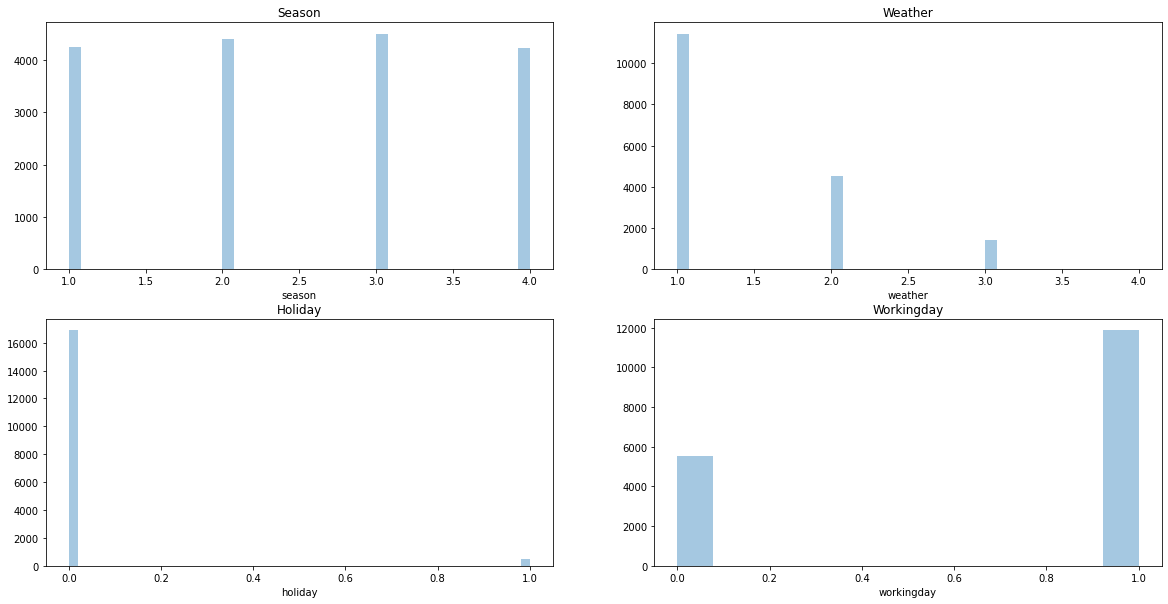

In [79]:
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sb.distplot(dataset["season"],kde=False,ax=ax[0,0])
sb.distplot(dataset["weather"],kde=False,ax=ax[0,1])
sb.distplot(dataset["holiday"],kde=False,ax=ax[1,0])
sb.distplot(dataset["workingday"],kde=False,ax=ax[1,1])

ax[0,0].set_title("Season")
ax[0,1].set_title("Weather")
ax[1,0].set_title("Holiday")
ax[1,1].set_title("Workingday")

- Hour trending:

In [87]:
# convert 'datetime' column to datetime datatype
dataset['datetime'] = pd.to_datetime(dataset['datetime'],format='%Y-%m-%d %H:%M:%S')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,4


In [95]:
# add 'hour' and 'date' columns
hours = []
for i in range(len(dataset['datetime'])):
  hours.append(dataset['datetime'][i].hour)
dataset["hour"] = hours
dates = []
for i in range(len(dataset['datetime'])):
  dates.append(dataset['datetime'][i].day)
dataset["date"] = dates

In [104]:
# divide dataset into train and test
dataset.head(5)
pd.to_numeric(dataset['date'])
train = dataset[dataset['date'] < 20]
test = dataset[dataset['date']>=20]

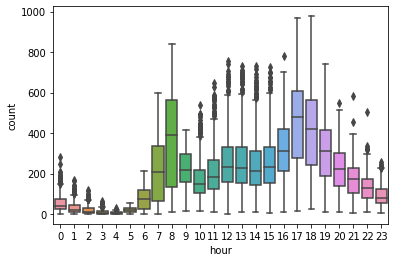

In [105]:
# boxplot bike rentals per hour in train set.
sb.boxplot(x='hour',y='count',data=train)

Text(0.5, 1.0, 'Registered')

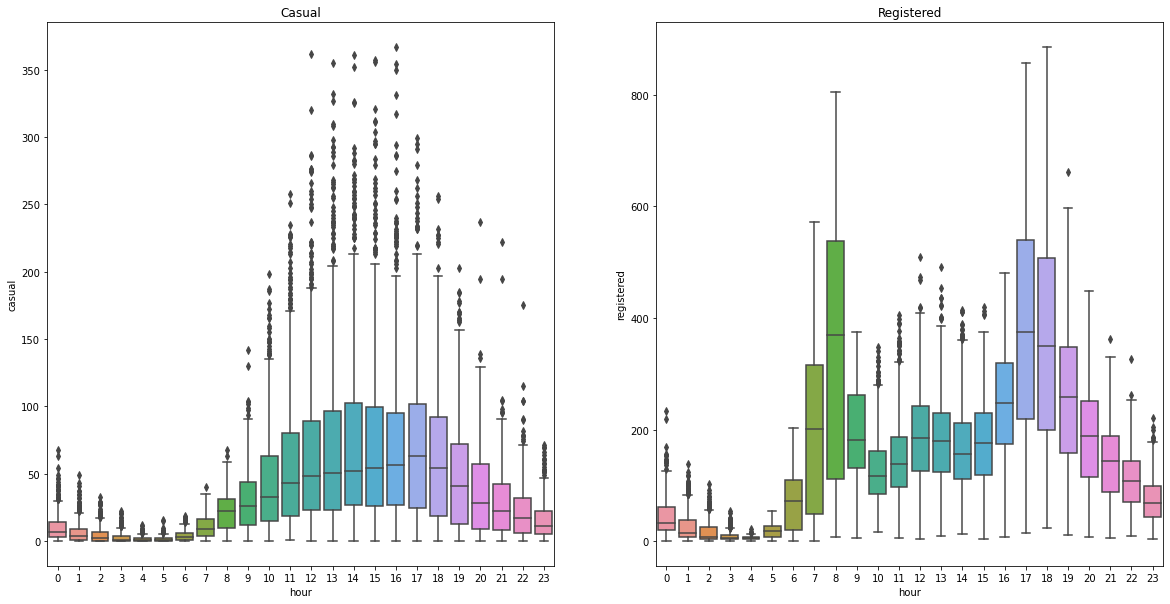

In [113]:
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='hour',y='casual',data=train,ax=axis1)
sb.boxplot(x='hour',y='registered',data=train,ax=axis2)

axis1.set_title('Casual')
axis2.set_title('Registered')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


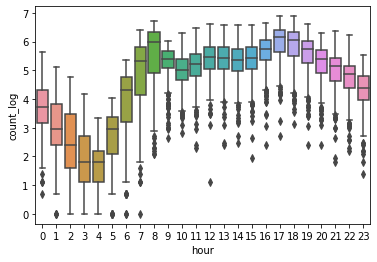

In [118]:
train['count_log'] = np.log(train['count'])
sb.boxplot('hour','count_log',data=train,)

Change datatype of 'datetime' column to datetime.
Get hour in 'datetime' column.

---



In [ ]:
dt_col = dataset['datetime']
print(dt_col)
hours = []
for i in range(0,len(dt_col)):
 x = datetime.strptime(dt_col[i], "%Y-%m-%d %H:%M:%S")
 hours.append(x.hour)

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object


In [ ]:
new_dataset = dataset.iloc[:,1:12]
new_dataset['hours'] = hours
new_dataset.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hours
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
5,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5
6,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6
7,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7
8,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,8
9,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,9


Create a correlation matrix.

In [ ]:
from seaborn import heatmap
import matplotlib.pyplot as plt

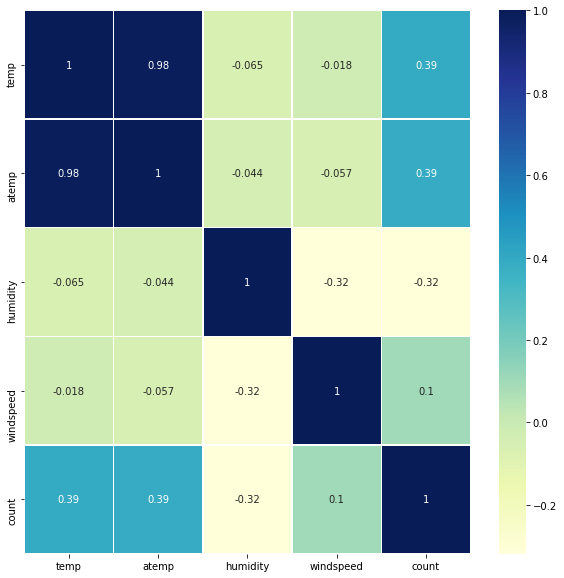

In [ ]:
continuous_data = new_dataset[['temp','atemp','humidity','windspeed','count']]
matrix_corr = continuous_data.corr()
plt.figure(figsize=(10,10))
heatmap(matrix_corr, cmap='YlGnBu', annot=True, annot_kws={"size":10}, linewidths=0.5)
plt.show()

In [ ]:
new_dataset = new_dataset[['hours','holiday','workingday','season','weather','temp','atemp',
                           'humidity','windspeed','count']]
new_dataset.head()

,hours,holiday,workingday,season,weather,temp,atemp,humidity,windspeed,count
0,0,0,0,1,1,9.84,14.395,81,0.0,16
1,1,0,0,1,1,9.02,13.635,80,0.0,40
2,2,0,0,1,1,9.02,13.635,80,0.0,32
3,3,0,0,1,1,9.84,14.395,75,0.0,13
4,4,0,0,1,1,9.84,14.395,75,0.0,1


Make a summaries of variables.

In [ ]:
print(new_dataset['temp'].describe())
print(new_dataset['atemp'].describe())
print(new_dataset['humidity'].describe())
print(new_dataset['windspeed'].describe())

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64
count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64
count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64
count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


In [ ]:
pd.crosstab(index=new_dataset['season'],columns=new_dataset['weather'],margins=True)

weather,1,2,3,4,All
season,,,,,
1,1759,715,211,1,2686
2,1801,708,224,0,2733
3,1930,604,199,0,2733
4,1702,807,225,0,2734
All,7192,2834,859,1,10886


In [ ]:
X = new_dataset.iloc[:,0:7]
print(X.head())
Y = new_dataset.iloc[:,-1]
print(Y.head())

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, train_size = 0.7, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7620, 7)
(3266, 7)
(7620,)
(3266,)


# Train model